### Import Library

In [1]:
import win32gui
import win32api
import win32con
import time
from PIL import ImageGrab
import ctypes
from ctypes import sizeof
from ctypes.wintypes import RECT
import cv2
import numpy as np
import pyautogui
from matplotlib import pyplot as plt

### CLASS

In [2]:
class Rgdm:
    
    def __init__(self): 
        """Set handle from window class name
        Make sure dispaly size 540x960 dpi240 in mobile"""
        
        self.__screen = None
        HWND_p = win32gui.FindWindow("LDPlayerMainFrame","LDPlayer")
        self.__HWND_c = win32gui.FindWindowEx(HWND_p, None , "RenderWindow","TheRender")
        print('Handle ID :{0}, Handle ID in 16:{1}'.format(self.__HWND_c, hex(self.__HWND_c)))
        
    def Click(self, x, y): 
        """Click function"""
        
        lParam = win32api.MAKELONG(x, y)
        win32gui.SendMessage(self.__HWND_c, win32con.WM_LBUTTONDOWN, win32con.MK_LBUTTON, lParam)
        time.sleep(0.2)
        win32gui.SendMessage(self.__HWND_c, win32con.WM_LBUTTONUP,win32con.MK_LBUTTON, lParam)
        
    def Drag(self,x_s,y_s,x_e,y_e): 
        """Drag from (x_s,y_s) to (x_e,y_e)"""
        
        lParam_start = win32api.MAKELONG(x_s, y_s)
        lParam_end = win32api.MAKELONG(x_e, y_e)
    
        #set iteration 
        ITE=10
        delx=(x_e-x_s)/ITE
        dely=(y_e-y_s)/ITE
        x=x_s
        y=y_s
    
        #click first
        win32api.SendMessage(self.__HWND_c, win32con.WM_LBUTTONDOWN,win32con.MK_LBUTTON, lParam_start)
        time.sleep(0.8)
    
        #move
        for i in range(ITE+1):
            lParam_ite = win32api.MAKELONG(x, y)
            win32api.SendMessage(self.__HWND_c, win32con.WM_MOUSEMOVE, 0, lParam_ite)
            time.sleep(0.05)
            x+=int(delx)
            y+=int(dely)
    
        #click up 
        time.sleep(0.2)
        win32api.SendMessage(self.__HWND_c, win32con.WM_LBUTTONUP,win32con.MK_LBUTTON, lParam_end)
        
    def Capture(self):
        """Capture __screen"""
        
        rect = win32gui.GetWindowRect(self.__HWND_c)
        grabed_image = ImageGrab.grab()
        croped_image = grabed_image.crop(rect)
        screen=np.asarray(croped_image)
        self.__screen=cv2.cvtColor(screen, cv2.COLOR_RGB2BGR)
        
    def Judge_Matching(self,num):
        """Judge whether success of detection"""
        
        THRESHOLD=0.7
        if THRESHOLD < num:
            return True
        else:
            return False
        
    def Judge_Matching_battle(self,num):
        """Judge whether success of detection"""
        
        THRESHOLD=0.8
        if THRESHOLD < num:
            return True
        else:
            return False
    
    def Matching(self,template):
        """Template Matching for detection of object"""
        
        #Size of image
        h, w = template.shape[0:2]
        # Apply template Matching
        res = cv2.matchTemplate(self.__screen,template,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        #Judge by threshold
        judge=self.Judge_Matching(max_val)
        print(judge)
        print("threshold=",max_val)
        # Show result
        screen_result=self.__screen.copy()
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        if judge==True:
            cv2.rectangle(screen_result,top_left, bottom_right,(255,0,0),10)
        else:
            cv2.rectangle(screen_result,top_left, bottom_right, (0,0,255),10)
        img_rgb = cv2.cvtColor(screen_result, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        center_x=top_left[0]+w/2
        center_y=top_left[1]+h/2
        return center_x, center_y,judge
        
    def Get_template(self):
        """Get template image"""
        
        #read image
        SOLO= cv2.imread('img/etc/solo.png',1)
        BATU= cv2.imread('img/etc/batu.png',1)
        HOME= cv2.imread('img/etc/home.png',1)
        MAIN= cv2.imread('img/etc/mainstory.png',1)
        START= cv2.imread('img/etc/start.png',1)
        START2= cv2.imread('img/etc/start2.png',1)
        OK= cv2.imread('img/etc/ok.png',1)
        SKIP= cv2.imread('img/etc/skip.png',1)
        #Make template 
        template=[START2, MAIN, HOME, START, OK, SOLO, BATU, SKIP]
        return template
        
    def Get_template_number(self):
        """Get template image"""
    
        #read image
        ONE= cv2.imread('img/number/1.png',1)
        TWO= cv2.imread('img/number/2.png',1)
        THREE= cv2.imread('img/number/3.png',1)
        FOUR= cv2.imread('img/number/4.png',1)
        FIVE= cv2.imread('img/number/5.png',1)
        SIX= cv2.imread('img/number/6.png',1)
        SEVEN= cv2.imread('img/number/7.png',1)
        #make template
        template=[SEVEN, SIX, FIVE, FOUR, THREE, TWO, ONE]
        return template
    
    def Get_template_battle(self):
        """Get template image"""
        
        #read image
        SUMMON= cv2.imread('img/battle/summon.png',1)
        TRIGGER= cv2.imread('img/battle/trigger.png',1)
        OK= cv2.imread('img/battle/ok.png',1)
    
        #make template
        template=[SUMMON, TRIGGER, OK]
        return template
    
    def To_battle(self,BATTLE_FLAG):
        """Proceding to battle __screen"""
        
        #Initialize
        NEXT_FLAG=False
    
        #Get __screen image
        self.Capture()
    
        #Get template
        template=self.Get_template()
    
        #Proceed battale 
        for i in range(len(template)):
            x,y,judge=self.Matching(template[i])
            if judge==True:
                self.Click(int(x),int(y))
                NEXT_FLAG=True
            
        #check battle 
        x,y,judge=self.Matching(cv2.imread('img/etc/battle.png',1))
        if judge==True:
            BATTLE_FLAG=True
            
        #random click       
        if NEXT_FLAG!=True:
            self.Click(400,200)#適当に中央クリック
            print("random click")
        
        return BATTLE_FLAG

### Let's Play 

In [3]:
#Generate instance
Rgdm = Rgdm()

Handle ID :67096, Handle ID in 16:0x10618


### To Battle

False
threshold= 0.220093235373497


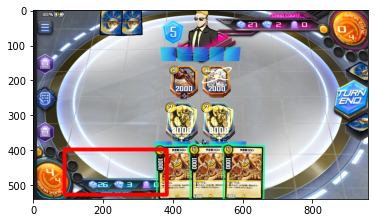

False
threshold= 0.40224578976631165


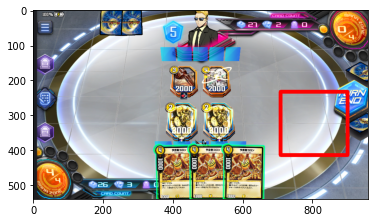

False
threshold= 0.25573042035102844


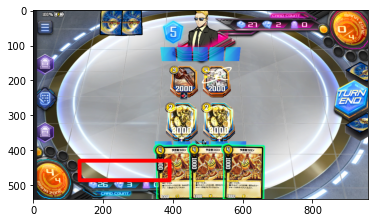

False
threshold= 0.36662912368774414


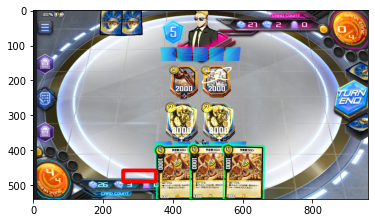

False
threshold= 0.32687973976135254


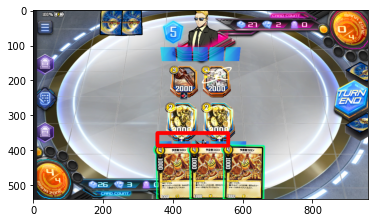

False
threshold= 0.35269516706466675


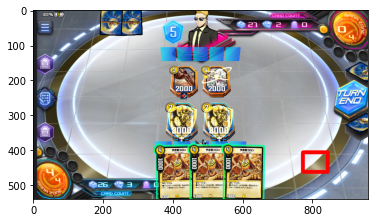

False
threshold= 0.4307209849357605


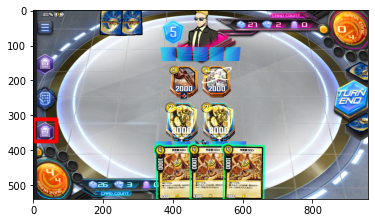

False
threshold= 0.5693312883377075


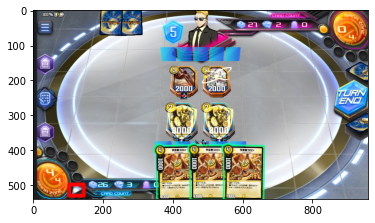

True
threshold= 0.999999463558197


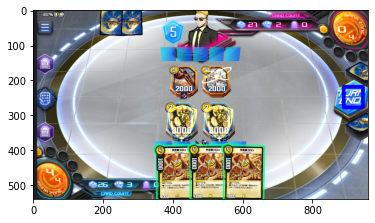

random click


In [4]:
BATTLE_FLAG = False
while BATTLE_FLAG == False:
    BATTLE_FLAG = Rgdm.To_battle(BATTLE_FLAG)

### Battle

False
threshold= 0.5874701738357544


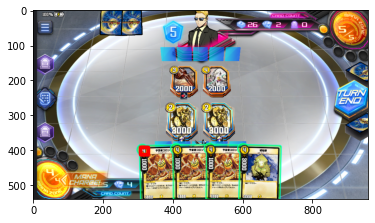

True
threshold= 0.7677576541900635


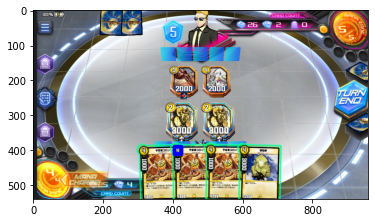

True
threshold= 0.9535342454910278


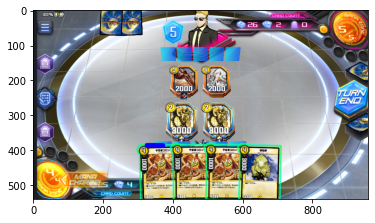

False
threshold= 0.2899738550186157


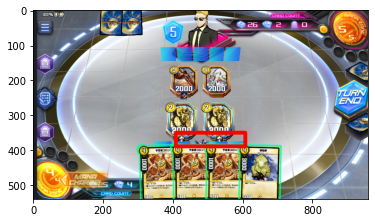

False
threshold= 0.27406060695648193


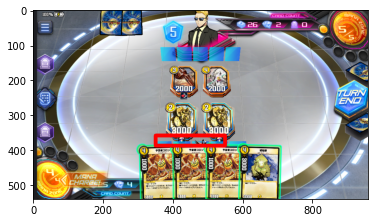

In [8]:
#Get screen image
Rgdm.Capture()
    
#Get template
template_number=Rgdm.Get_template_number()
template_battle=Rgdm.Get_template_battle()

#Battle
#send card to mana zone 
for i in range(len(template_number)):
    x,y,judge=Rgdm.Matching(template_number[i])
    if judge==True:
        Rgdm.Drag(int(x+10),int(y+10), 40, 508)
        break

#summon monster(shape is important)
for i in range(len(template_battle)):
    x,y,judge=Rgdm.Matching(template_battle[i])
    if judge==True:
        Rgdm.Drag(int(x),int(y+50), 480, 270)
    else:
        continue
#matching threathold渡す
#for(;;) break この中にfor(;;) break or while バトル中、バトルまでとか
#画像のキャプチャー考える